# Introduction to Dynamical Systems
### Reference Case Conviction Voting

## A Brief Intro
Dynamical Systems are mathematical structures which describe evolution over time. Historically they are analyzed in Continuous Time because they are used to design, test and control physical systems. Over recent decades they have also been used to design, test and control computer systems. They are powerful abstractions that have helped manage the relationships between physical and computational systems, and even social systems (as they are critical ingredients in stochastic dynamic genereal equilibrium models which are used in macroeconomics). Whether continuous or discrete dynamical systems are traditional associated with real valued vectors, matrices and tensors. Moving away from real valued fields, we can define dynamical systems over arbitrary data structures to recover a broader family models inckuding but not limited to agent based models. In the case of the conviction voting cadCAD model we have a Generalized Dynamical System whose state contains a network object encoding a range of relationships as well as both numerical and non-numerical information. For the purpose of this short explainer, we will zoom in specifically on the calculation of conviction itself, which we can understand a Discrete Linear Time Invariant (LTI) system. 


## Canonical Forms

Canonical forms use $x_t$ for the state of the system, and $u_t$ to describe inputs from external systems.

Continous-time Non-linear Dynamical System:

$\dot x_t = f(x_t, u_t)$

Continuous-time Linear Time Invariant (LTI) Dynamical Systems:

$\dot x_t = A x_t + B u_t$

Discrete-time Non-linear Dynamical System:

$x_{k+1} = f(x_k, u_k)$

Discrete-time Linear Time Invariant (LTI) Dynamical Systems:

$x_{k+1} = A x_k + B u_k$

For cases where the discrete time system can be embedded directly in a continuous time, the time indexes can be mapped directly:

|**Time Index Mapping Table 1** |
| ---: | :--- | :--- | :--- | :--- | :--- | :--- | :---  | :--- |
| **discrete-time** | $0$, | $1$, | ,$\ldots$, | $k-1$, | $k$, | $k+1$, | $k+2$, | $\ldots$|
| **continuous-time** | $0$, |$\Delta t$ | ,$\ldots$, |$t-\Delta t$, | $t$, | $t+\Delta t$, |$t+2\Delta t$, |$\ldots$| 

For systems comprised of discrete events with strict ordering (eg state machines), we have any mapping that respects the order

|**Time Index Mapping Table 2** |
| ---: | :--- | :--- | :--- | :--- | :--- | :--- | :---  | :--- |
| **discrete-time** | $0$, | $1$, | ,$\ldots$, | $k-1$, | $k$, | $k+1$, | $k+2$, | $\ldots$|
| **continuous-time** | $t_0$, |$t_1$ | ,$\ldots$, |$t_{k-1}$, | $t_k$, | $t_{k+1}$, |$t_{k+2}$, |$\ldots$| 
| **time delta** |  | $t_1-t_0$ |  ,$\ldots$, | $t_{k-1} -t_{k-2}$, | $t_{k} -t_{k-1}$, | $t_{k+1} -t_{k}$, |$t_{k+2} - t_{k+1}$, |$\ldots$| 

noting that the time deltas can be further denoted $\Delta t_k =t_{k} -t_{k-1}$, such that $t_k = t_0+\sum_{\kappa =0}^{k-1} \Delta t_k$ for all $k>0$.


## Translating the Simplified Conviction Voting Example

Suppose we start by only considering a single proposal and a single participant voting for that proposal. The conviction voting algorithm is **not** presented in canonical notion. In our case the state we are interested in is the conviction $y_t$ and the inputs from the external system are the actions of partipants staking a quantity of tokens $x_t$. Based on the notes above the canonical form would call conviction $x_k$ and the tokens staked $u_k$, but the table below includes the definitions that match the conviction voting documentation:

$y_{t+1} = \alpha y_t + x_t$

| Term  | Canonical Notation | Defintion| Alternative notation|
| :--:| :--: | :--:| :--: |
| Conviction | $x_k$ | the accumulated support for the proposal at epoch $k$ | $y_t$|
| Support | $u_k$ | the number of tokens staked in support of the proposal at epoch $k$| $x_t $ |

Expressed in the Canonical form we have:

$x_{k+1} = A x_k + B u_k$

with $A = \alpha$ and $B=1$, yielding

$x_{t+k} = \alpha x_k + u_k$

For ease of reading we will stick to the notation in the other conviction voting documentation for the rest of this note but we recommend using the translation to the canonical form when refering to literature on dynamical systems to learn more.


## Properties via the Simplified Example

A one dimension Discrete-time LTI systems with initial condition $y_0$

$y_{t+1} = \alpha y_t + x_t$

which can also be expressed as

$y_{t+1}-y_t=\Delta y_t = -(1-\alpha) y_t + x_t$

and as

$y_T = y_0 +\sum_{t=0}^{T-1} \Delta y_t = \alpha^T y_0  + \sum_{t=0}^{T-1} \alpha^t \bar x$ when $x_t = \bar x$ is a constant, thanks to telescoping series. we can also project the eventual conviction for any constant $x$ as

$\hat y(x) = \lim_{T\rightarrow \infty} \left( \alpha^T y_0+\sum_{t=0}^{T-1} \alpha^t x\right) = \frac{x}{1-\alpha}$ using geometric series.

The first most important property is "stability". This is an entire topic in its own right but let's suffice to observe that as long as $\alpha \in [0,1)$ then growth in $y_t$ is bounded. In particular, for any $x$ this system is stable around the equilibrium $\hat y(x_t) = \frac{x_t}{(1-\alpha)}$, even if $y_t \neq \hat y(x_t)$. In this way, our algorithm is tracking the signal $y_t$ can be thought of tracking the signal $\frac{x_t}{1-\alpha}$ with some intertia muting the volatility.

The equation $\hat y(x) = \frac{x}{(1-\alpha)}$ tells us precisely that each token in a conviction voting system contributes at most $\frac{1}{1-\alpha}$ "conviction" toward passing the proposal.

Clearly, this expression goes unstable when $\alpha =1$, in which case our algorithm diverges. Consider the sum over time to see the instability:

$\lim_{T\rightarrow \infty} y_T \ge \lim_{T\rightarrow \infty} \sum_{t=0}^{T-1} \bar x = \infty$

for strictly positive values $x_t\ge \bar x >0$ as $T\rightarrow \infty$.

So in conviction voting we require that $\alpha\in [0,1)$. Technically it is legal to set $\alpha = 0$ at which point this system simply $y_{t+1} = x_t$ sets the conviction to the amount of tokens staked. Although, $x_t$ can still vary overtime, there is no accumulation. The choice of $\alpha>0$ is made to create a "leaky integrator" which takes its name from a leaky bucket analogy.
![](https://i.imgur.com/JemMMlo.png)

The leaky bucket analogy also helps us understand $\alpha$ in terms of its relationshio to the "half-life" of the fluid in the bucket when we turn off the inflow. In this case there is some previously accumated conviction in our initial condition $y_0 >0$ but $x_t = 0$. In this case the dynamics are simply:

$y_{t+1} = \alpha y_t$ 

which is equivalent to 

$y_T = \alpha^T y_0$

The half-life of this system is defined by $T$ such that $y_T = y_0/2$ which satisfies the equation

$\frac{1}{2}  = \alpha^T$

thus the Half life in epochs for a given $\alpha$ is

$T = -\log_\alpha 2$

and conversely the $\alpha$ which achieves a desired half-lige $T$ is

$\alpha = 2^{-1/T}$

Further note that the relationship between $T$ and $\alpha$ is sensative to timescaling. Suppose we wanted a half-life of 3 days but our discrete time scale has 1 hour epochs, then we must use $T = 24 \times 3 = 72$ in the above equation.


In [1]:
#consider a desired half life of 7 periods (day)
# then alpha is given by
alpha = 2**(-1/7)
print(alpha)
#note that if the implementation has epochs of such that there are 24 updates per period (day)
#then the implementation alpha would be
alpha = 2**(-1/(7*24))
print(alpha)

0.9057236642639067
0.9958826236582974


In [2]:
import numpy as np
import matplotlib.pyplot as plt

alpha=.9

time = np.arange(0,200,1)

K = len(time)

step_up = np.zeros(K)
step_down = np.ones(K)
noisy = np.random.rand(K)

for k in range(K): 
    if k>K/2:
        step_up[k]=1
        step_down[k]=0

step_up_response = np.empty(K)
step_up_response[0]=0

step_down_response = np.empty(K)
step_down_response[0]=0#1/(1-alpha)

noisy_response = np.empty(K)
noisy_response[0] = 0
for k in range(K-1):
    step_up_response[k+1] = alpha*step_up_response[k] + step_up[k]
    step_down_response[k+1] = alpha*step_down_response[k] + step_down[k]
    noisy_response[k+1] = alpha*noisy_response[k] + noisy[k]

Text(0, 0.5, 'Conviction Accumulated')

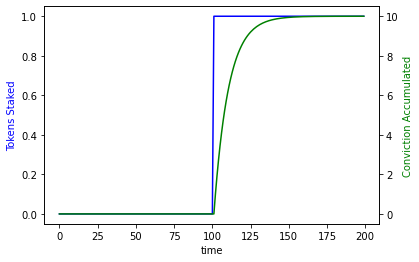

In [3]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, step_up, 'b-')
ax2.plot(time, step_up_response, 'g-')

ax1.set_xlabel('time')
ax1.set_ylabel('Tokens Staked', color='b')
ax2.set_ylabel('Conviction Accumulated', color='g')

Text(0, 0.5, 'Conviction Accumulated')

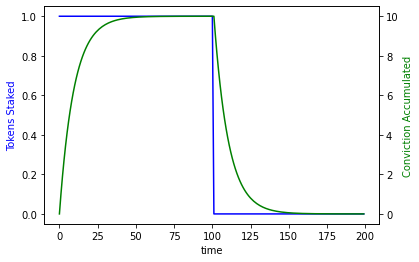

In [4]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, step_down, 'b-')
ax2.plot(time, step_down_response, 'g-')

ax1.set_xlabel('time')
ax1.set_ylabel('Tokens Staked', color='b')
ax2.set_ylabel('Conviction Accumulated', color='g')

(0.0, 10.472349981579981)

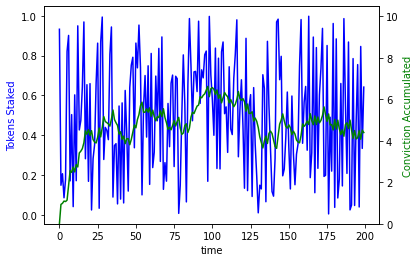

In [5]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, noisy, 'b-')
ax2.plot(time, noisy_response, 'g-')

ax1.set_xlabel('time')
ax1.set_ylabel('Tokens Staked', color='b')
ax2.set_ylabel('Conviction Accumulated', color='g')

ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

The above plot shows the signal processing power of the conviction voting algorithm. It effectively computes a time average scaled by a factor $\frac{1}{1-\alpha}$. In fact, one variant of conviction voting would include this normalization, creating an exponentially smoothed weighted average. However, in the basic version we choose to define it as a leaky integrator because we wanted to make explicit the value of ones votes accumulates over time to more than what one would attain in a standard voting method: $x< \frac{x}{1-\alpha}$ whenenver $\alpha\in (0,1)$.

## Multidimensional Example

Now in order to proced with this example we need to make it a little less simple by considering a case where there are $n$ participants and $m$ proposals. In this case the signals are distributed across the agents. That is to say each agent $i$ will get to chose there stake for each proposal $j$ based on their private preferences. They can make that decision however they want as long as the action they take is valid.

Suppose participant $i$ has $h_t[i]$ tokens at time $t$, then they may choose to stake them accross the available proposals $\vec x_t[i] = \big[x_t[i,0], \ldots, x_t[i,m] \big]$ where $x_t[i,j]$ is the number of tokens staked by participant $i$ in support of proposal $j$.  The staking action is valid as long as $\sum_{j =0}^{m-1} x_t[i,j] \le h_t[i]$.

The information used to decide on $\vec x_t[i]$ is private to agent $i$. Furthermore, in cases where $h_t[i]$ is variable (due to transferability of tokens), the quantity $h_t[i]$ itself is a decision as a consequence of private information related to agent $i$. For the purpose of this discussion, we don't worry about how agent $i$ decides to hold $h[i]$ or chooses to support proposals according to $\vec x_t [i]$ but we do assume that in doing so she is expressing some of her private information, both magnitude $h_t[i]$ and direction $\vec x_t[i]$.

Given the choices for all participants we have a time varying matrix made up of terms $x_t[i,j]$:

$X_t = \left[\begin{array}{c}\vec x_t[0]\\ \vdots \\ \vec x_t[n-1]   \end{array}\right] \in \mathbb{R}_+^{n \times m}$

satisfying the condition that $X_t \vec{\mathbf{1}} \le \vec h_t$ for all time $t$ where $\vec{\mathbf{1}}$ is the $m$ dimensional column vector of ones and $\vec{h}_t$ is the $n$ dimensional column vector of holdings. 

The most interesting thing about building this matrix view of the system is how it unifies the local and global states of the system. Surely each agent will make their own choices about $x_t[i,j]$ and $h_t[t]$ and those choices will vary in time based on a wide range of factors that we cannot hope to totally understand, but we do know that even as it varies in time our actors are using the freedoms afforded to them by this policy to move the system towards outcomes they percieve as best relative to their private preferences and information. The key to our algorithm is to compile that spatially distributed time varying singal into a discrete decision. We do this by restating our conviction voting algorithm in its matrix form:

$\vec{y}_{t+1} = \alpha \vec{y}_t  + X_t' \vec{\mathbb{1}}$ where $X_t'$ is the transpose of $X_t$ and $\vec{\mathbb{1}}$ is the $n$ dimensional column vector of ones. This expression is equivalent to

$y_{t+1}[j] = \alpha y_{t} + \sum_{i} x_t[i,j]$ where $\vec{y}_t = \left[\begin{array}{c}y_t[0]\\ \vdots \\ \vec y_t[m-1]   \end{array}\right] \in \mathbb{R}_+^{m}$

This mathematical structure is actually the same as the one we demonstrated in the one dimensional case so we will review some the same checks.

In [6]:
import pandas as pd

n = 3
m = 2

mimo_step_up = np.zeros(shape=(K,n,m))
mimo_step_down = np.zeros(shape=(K,n,m))
mimo_noisy = np.random.rand(K*m*n).reshape((K,n,m))

for k in range(K): 
    for i in range(n):
        for j in range(m):
            if k>2*K/(i+3):
                mimo_step_up[k,i,j]= (1+i)*(1+j)
                mimo_step_down[K-k,i,j]= (1+i)*(1+j)

In [7]:

mimo_step_up_response = np.empty(shape=(K,m))
mimo_step_up_response[0,:]=0

mimo_step_down_response = np.empty(shape=(K,m))
mimo_step_down_response[0,:]= 1/(1-alpha)*np.sum(mimo_step_down[0,:,:])

mimo_noisy_response = np.empty(shape=(K,m))
mimo_noisy_response[0,:]=0


In [8]:

for k in range(K-1):
    mimo_step_up_response[k+1,:] = alpha*mimo_step_up_response[k,:] + np.sum(mimo_step_up[k,:,:], 0)
    mimo_step_down_response[k+1,:] = alpha*mimo_step_down_response[k,:] + np.sum(mimo_step_down[k,:,:],0)
    mimo_noisy_response[k+1,:] = alpha*mimo_noisy_response[k,:] + np.sum(mimo_noisy[k,:,:],0)

## Filling up the tank

A set of tests where the participants start supporting a proposal but their support starts at different times
- granular input signals
- aggregate inputs with outputs
- granular inputs with outputs

Text(0.5, 1.0, 'step_up tokens staked for proposal 1')

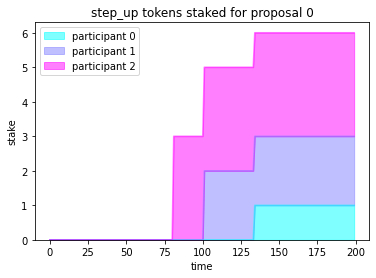

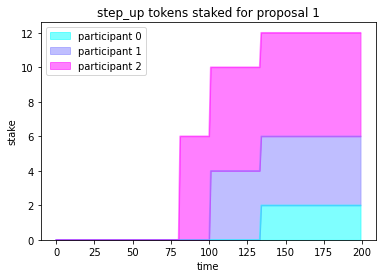

In [9]:
pd.DataFrame(mimo_step_up[:,:,0], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool')
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 0')
pd.DataFrame(mimo_step_up[:,:,1], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool')
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 1')

Text(0.5, 1.0, 'Conviction and tokens staked for proposals 0 and 1')

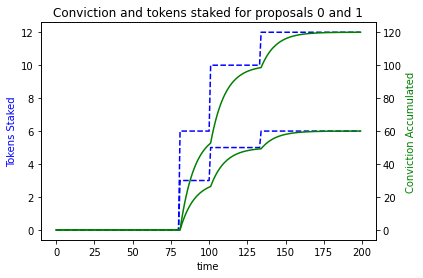

In [10]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, np.sum(mimo_step_up, 1), 'b--')
ax2.plot(time, mimo_step_up_response, 'g-')

ax1.set_xlabel('time')
ax1.set_ylabel('Tokens Staked', color='b')
ax2.set_ylabel('Conviction Accumulated', color='g')

plt.title('Conviction and tokens staked for proposals 0 and 1')

Text(0.5, 1.0, 'Support for Proposal 1')

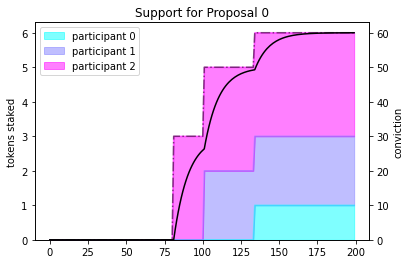

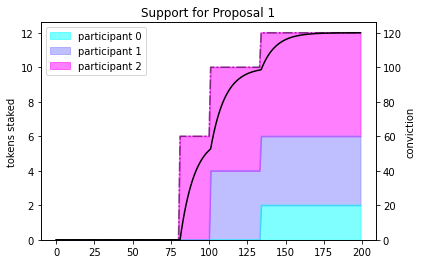

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pd.DataFrame(mimo_step_up[:,:,0], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool', ax=ax1)
ax1.plot(time, np.sum(mimo_step_up[:,:,0],1), 'k-.', alpha=.5)
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 0')
ax2.plot(time, mimo_step_up_response[:,0], 'k-')
ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

plt.xlabel('time')
ax1.set_ylabel('tokens staked')
ax2.set_ylabel('conviction')
plt.title('Support for Proposal 0')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pd.DataFrame(mimo_step_up[:,:,1], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool', ax=ax1)
ax1.plot(time, np.sum(mimo_step_up[:,:,1],1), 'k-.', alpha=.5)
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 1')

ax2.plot(time, mimo_step_up_response[:,1], 'k-')
ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

plt.xlabel('time')
ax1.set_ylabel('tokens staked')
ax2.set_ylabel('conviction')
plt.title('Support for Proposal 1')

## Emptying up the tank

A set of tests where the participants start supporting a proposal but their support starts at different times
- granular input signals
- aggregate inputs with outputs
- granular inputs with outputs

Text(0.5, 1.0, 'step_up tokens staked for proposal 1')

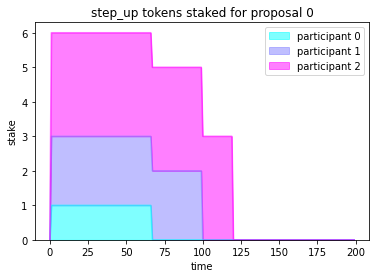

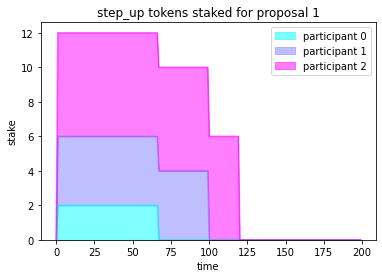

In [12]:
pd.DataFrame(mimo_step_down[:,:,0], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool')
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 0')
pd.DataFrame(mimo_step_down[:,:,1], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool')
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 1')

Text(0.5, 1.0, 'Conviction and tokens staked for proposals 0 and 1')

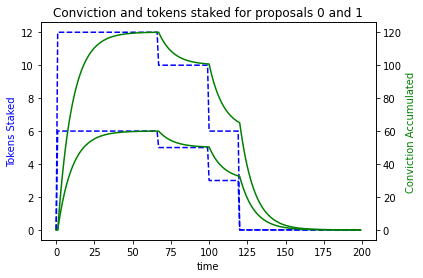

In [13]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, np.sum(mimo_step_down, 1), 'b--')
ax2.plot(time, mimo_step_down_response, 'g-')

ax1.set_xlabel('time')
ax1.set_ylabel('Tokens Staked', color='b')
ax2.set_ylabel('Conviction Accumulated', color='g')

plt.title('Conviction and tokens staked for proposals 0 and 1')

Text(0.5, 1.0, 'Support for Proposal 1')

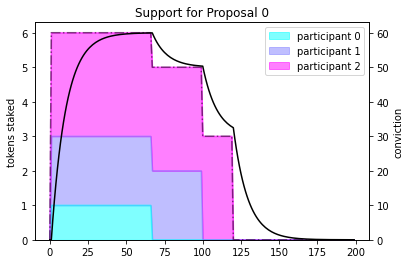

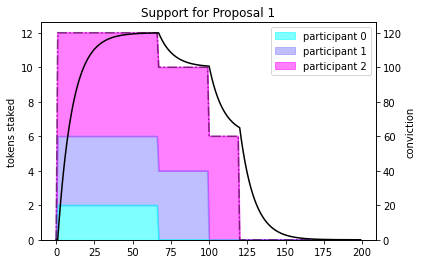

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pd.DataFrame(mimo_step_down[:,:,0], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool', ax=ax1)
ax1.plot(time, np.sum(mimo_step_down[:,:,0],1), 'k-.', alpha=.5)
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 0')
ax2.plot(time, mimo_step_down_response[:,0], 'k-')
ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

plt.xlabel('time')
ax1.set_ylabel('tokens staked')
ax2.set_ylabel('conviction')
plt.title('Support for Proposal 0')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pd.DataFrame(mimo_step_down[:,:,1], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool', ax=ax1)
ax1.plot(time, np.sum(mimo_step_down[:,:,1],1), 'k-.', alpha=.5)
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 1')

ax2.plot(time, mimo_step_down_response[:,1], 'k-')
ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

plt.xlabel('time')
ax1.set_ylabel('tokens staked')
ax2.set_ylabel('conviction')
plt.title('Support for Proposal 1')


## Noisy inputs: constantly filling and emptying at the same time

A set of tests where the participants start supporting a proposal but their support starts at different times
- aggregate inputs with outputs
- granular inputs with outputs

(0.0, 29.705970965941468)

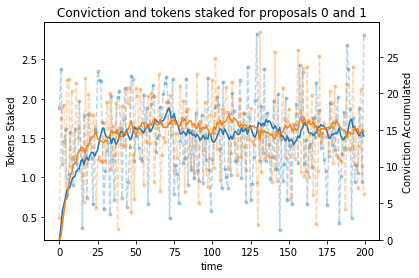

In [15]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time, np.sum(mimo_noisy, 1), '.--', alpha=.3)
ax2.plot(time, mimo_noisy_response)

ax1.set_xlabel('time')
ax1.set_ylabel('Tokens Staked')
ax2.set_ylabel('Conviction Accumulated')

plt.title('Conviction and tokens staked for proposals 0 and 1')


ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

Text(0.5, 1.0, 'Support for Proposal 1')

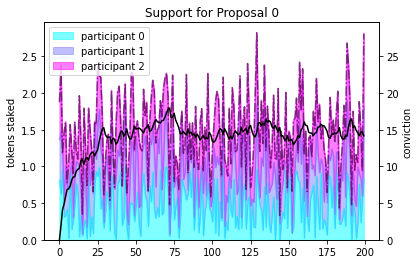

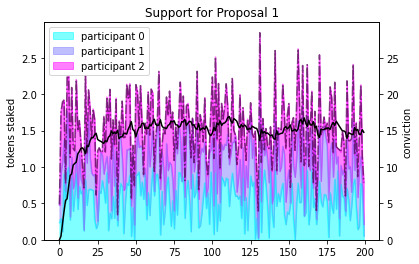

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pd.DataFrame(mimo_noisy[:,:,0], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool', ax=ax1)
ax1.plot(time, np.sum(mimo_noisy[:,:,0],1), 'k-.', alpha=.5)
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 0')

ax2.plot(time, mimo_noisy_response[:,0], 'k')
ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

plt.xlabel('time')
ax1.set_ylabel('tokens staked')
ax2.set_ylabel('conviction')
plt.title('Support for Proposal 0')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

pd.DataFrame(mimo_noisy[:,:,1], columns = ['participant 0', 'participant 1', 'participant 2']).plot(kind='area', alpha = .5, cmap = 'cool', ax=ax1)
ax1.plot(time, np.sum(mimo_noisy[:,:,1],1), 'k-.', alpha=.5)
plt.xlabel('time')
plt.ylabel('stake')
plt.title('step_up tokens staked for proposal 1')

ax2.plot(time, mimo_noisy_response[:,1], 'k')
ylim= ax1.get_ylim()
ax2.set_ylim(0, ylim[1]/(1-alpha))

plt.xlabel('time')
ax1.set_ylabel('tokens staked')
ax2.set_ylabel('conviction')
plt.title('Support for Proposal 1')